# 实验六：Python网络爬虫实战

1.	认真阅读三篇文献资料，了解互联网开源数据和证券市场的相关研究，重点关注其中的研究思路和分析方法。

2.	利用所给Data_600618中的数据文件，结合正则表达式提取出股票600618的日度数据（日期，开盘，最高，最低，收盘，成交量，成交金额），并输出至csv文件，在实验报告中给出数据截图。

3.	在东方股吧下载“长久物流吧”（`https://guba.eastmoney.com/list,603569.html`）所有发帖数据（建议以班级为单位组队分工爬取，每人爬十几页），提取出帖子作者，发帖时间，阅读量，评论数，帖子标题，帖子链接，并将结果输出至文本文件“data_guba_cjwl.txt”。

4.	利用新浪数据接口读取长久物流的历史日度数据，接口数据链接： 
`http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/CN_MarketData.getKLineData?symbol=sh603569&scale=240&ma=no&datalen=10000`
从返回的数据中提取，交易日，开盘，最高，最低，收盘，成交量数据，并将结果输出至文本文件“data_sina_cjwl.txt”。

5.	构建股吧信息量指标（根据发帖时间、阅读量、评论数、帖子标题自行设计指标），将该指标作为预测因子，检验其对长久物流的超额收益率是否具有可预测性。

## 正则表达式提取 600618 的日度数据

In [1]:
import os
import re
import csv
import json

In [2]:
def extract_data_2009_2013(html):
    data = []
    table = re.search(r'<table class="table_bg001 border_box limit_sale">[\s\S]*?</table>', html)
    if not table:
        return []
    rows = re.findall(r'<tr class=[\'"]?(?:dbrow|)[\'"]?><td>[\s\S]*?</tr>', table.group(0))
    for row in rows:
        try:
            cells = re.findall(r'<td[^>]*>([\s\S]*?)</td>', row)
            if len(cells) < 11:
                continue
            data.append({
                'date': cells[0],
                'open': float(cells[1]),
                'high': float(cells[2]),
                'low': float(cells[3]),
                'close': float(cells[4]),
                'change': float(cells[5]),
                'change_percent': float(cells[6]),
                'volume': int(cells[7].replace(',', '')),
                'amount': float(cells[8].replace(',', '')) * 10000,
                'amplitude': float(cells[9]),
                'turnover_rate': float(cells[10])
            })
        except:
            continue
    return data

def extract_data_before_2014(html):
    if 'table_bg001 border_box limit_sale' in html:
        return extract_data_2009_2013(html)

    def parse_common(pattern):
        return [{
            'date': m[0],
            'open': float(m[1]),
            'high': float(m[2]),
            'close': float(m[3]),
            'low': float(m[4]),
            'volume': int(m[5]),
            'amount': int(m[6])
        } for m in re.findall(pattern, html, re.DOTALL)]

    if "[考试顺利]" in html:
        if "href=" in html or "target='_blank'" in html:
            pattern_2007 = r'<tr[^>]*>\s*<td><div[^>]*>\[考试顺利\]\s*(?:<a[^>]*>)?\s*([\d-]+)\s*(?:</a>)?[^<]*</div></td>\s*' \
                           r'<td><div[^>]*>\[考试顺利\]([\d.]+)</div></td>\s*' \
                           r'<td><div[^>]*>\[考试顺利\]([\d.]+)</div></td>\s*' \
                           r'<td><div[^>]*>\[考试顺利\]([\d.]+)</div></td>\s*' \
                           r'<td[^>]*><div[^>]*>\[考试顺利\]([\d.]+)</div></td>\s*' \
                           r'<td[^>]*><div[^>]*>\[考试顺利\](\d+)</div></td>\s*' \
                           r'<td[^>]*><div[^>]*>\[考试顺利\](\d+)</div></td>'
            return parse_common(pattern_2007)
        else:
            pattern_2004 = r'<tr[^>]*>\s*<td><div[^>]*>\[考试顺利\]\s*([\d-]+)\s*</div></td>\s*' \
                           r'<td><div[^>]*>\[考试顺利\]([\d.]+)</div></td>\s*' \
                           r'<td><div[^>]*>\[考试顺利\]([\d.]+)</div></td>\s*' \
                           r'<td><div[^>]*>\[考试顺利\]([\d.]+)</div></td>\s*' \
                           r'<td[^>]*><div[^>]*>\[考试顺利\]([\d.]+)</div></td>\s*' \
                           r'<td[^>]*><div[^>]*>\[考试顺利\](\d+)</div></td>\s*' \
                           r'<td[^>]*><div[^>]*>\[考试顺利\](\d+)</div></td>'
            return parse_common(pattern_2004)
    else:
        pattern_1999 = r'<tr\s+(?:class="tr_2"|)>\s*<td><div align="center">\s*([\d-]+)\s*</div></td>\s*' \
                       r'<td><div align="center">([\d.]+)</div></td>\s*' \
                       r'<td><div align="center">([\d.]+)</div></td>\s*' \
                       r'<td><div align="center">([\d.]+)</div></td>\s*' \
                       r'<td[^>]*><div align="center">([\d.]+)</div></td>\s*' \
                       r'<td[^>]*><div align="center">(\d+)</div></td>\s*' \
                       r'<td[^>]*><div align="center">(\d+)</div></td>'
        return parse_common(pattern_1999)

def extract_data_after_2014(js):
    match = re.search(r'historySearchHandler\((.*)\)', js)
    if not match:
        return []
    try:
        json_data = json.loads(match.group(1))
        hq = json_data[0].get('hq', []) if json_data and isinstance(json_data, list) else []
        return [{
            'date': i[0],
            'open': float(i[1]),
            'high': float(i[6]),
            'low': float(i[5]),
            'close': float(i[2]),
            'volume': int(i[7]) * 100,
            'amount': float(i[8].replace(',', '')) * 10000 if isinstance(i[8], str) else float(i[8]) * 10000
        } for i in hq]
    except:
        return []

In [3]:
def process_file(file_path):
    """
    处理单个文件，提取股票数据
    """
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()
    
    # 根据文件名判断数据格式
    if any(year in file_path for year in ['2014', '2015', '2016', '2017', '2018', '2019']):
        return extract_data_after_2014(content)
    else:
        return extract_data_before_2014(content)

def process_pipeline():
    # 数据文件所在的目录
    data_dir = './assets/data/Data_600618'  

    # 查找所有相关的数据文件
    all_data = []
    for filename in os.listdir(data_dir):
        if filename.startswith('DataHTML_600618_Year_') and filename.endswith('.txt'):
            file_path = os.path.join(data_dir, filename)
            file_data = process_file(file_path)
            all_data.extend(file_data)
    
    print(f"总共提取了 {len(all_data)} 条记录")
    
    # 按日期排序
    all_data.sort(key=lambda x: x['date'])
    
    # 输出到CSV文件
    output_file = './assets/data/股票600618日度数据.csv'
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        # 写入表头
        writer.writerow(['日期', '开盘价', '最高价', '最低价', '收盘价', '成交量(股)', '成交金额(元)'])
        # 写入数据
        for item in all_data:
            writer.writerow([
                item['date'],
                item['open'],
                item['high'],
                item['low'],
                item['close'],
                item['volume'],
                item['amount']
            ])
    
    print(f"数据已成功提取并保存到 {output_file}")

In [4]:
process_pipeline()

总共提取了 4775 条记录
数据已成功提取并保存到 ./assets/data/股票600618日度数据.csv


## 长久物流吧 数据爬取

这里很容易被封ip（只能爬取到方正证券的数据），建议采用代理解决，快代理可以免费使用一天。

由于后续还要处理爬到的数据，为了处理方便，这里改txt为csv。

股吧的帖子详情界面才能有带年份的时间，否则只有月份和日期，下面这份代码为了爬取带年份的，对每个详情页都进行了抓取，因此运行较慢，实际体验约10多个小时

In [5]:
import os
import time
import random
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# 配置参数
STOCK_ID = "603569"  # 长久物流的股票代码
STOCK_NAME = "长久物流"  # 股票名称，用于验证
BASE_URL = f"https://guba.eastmoney.com/list,{STOCK_ID},f_{{page}}.html"
OUTPUT_DIR = "./assets/data"
OUTPUT_FILE = os.path.join(OUTPUT_DIR, "data_guba_cjwl.csv")
MAX_PAGES = 1000  # 设置一个足够大的值爬取所有页面
MAX_THREADS = 5  # 详情页爬取的最大线程数

# 代理设置
PROXY_USER = "t14428474946629"
PROXY_PASS = "k0fxm4s0"
PROXY_HOST = "x368.kdltpspro.com:15818"

# 请求计数器(每3次强制切换IP)
request_counter = 0
# 锁对象 - 用于多线程环境下的文件写入
file_lock = None

def get_proxies():
    """获取代理配置"""
    return {
        "http": f"http://{PROXY_USER}:{PROXY_PASS}@{PROXY_HOST}",
        "https": f"http://{PROXY_USER}:{PROXY_PASS}@{PROXY_HOST}"
    }

def get_headers():
    """获取随机UA"""
    try:
        ua = UserAgent()
        user_agent = ua.random
    except:
        user_agents = [
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:89.0) Gecko/20100101 Firefox/89.0',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.0 Safari/605.1.15',
            'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36'
        ]
        user_agent = random.choice(user_agents)
    
    return {
        'User-Agent': user_agent,
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
        'Accept-Language': 'zh-CN,zh;q=0.9,en;q=0.8',
        'Connection': 'close',  # 非常重要，确保不复用连接，这样可以获取新IP
        'Cache-Control': 'no-cache'
    }

def force_new_ip():
    """强制获取新IP - 通过简单的请求测试站点来切换"""
    global request_counter
    request_counter = 0  # 重置计数器
    
    try:
        # 对测试站点发起请求以更换IP
        test_url = "https://dev.kdlapi.com/testproxy"
        proxies = get_proxies()
        headers = get_headers()
        
        print("正在切换IP...")
        response = requests.get(test_url, proxies=proxies, headers=headers, timeout=10)
        if response.status_code == 200:
            print("IP已切换")
            return True
    except Exception as e:
        print(f"切换IP时出错: {e}")
    
    return False

def get_page(url, retry_limit=3):
    """获取页面内容"""
    global request_counter
    
    # 每3次请求强制更换IP
    request_counter += 1
    if request_counter >= 3:
        force_new_ip()
    
    proxies = get_proxies()
    headers = get_headers()
    
    retry_count = 0
    while retry_count < retry_limit:
        try:
            # 创建新的session以确保不复用连接
            session = requests.Session()
            session.keep_alive = False
            
            # 添加随机延迟
            time.sleep(random.uniform(3, 7))
            
            # 发送请求
            response = session.get(url, proxies=proxies, headers=headers, timeout=15)
            response.encoding = 'utf-8'
            
            # 检查是否被重定向到其他股票
            if STOCK_NAME not in response.text and ("方正证券" in response.text or "验证码" in response.text):
                print(f"检测到被重定向或需要验证码，尝试切换IP...")
                force_new_ip()
                retry_count += 1
                continue
            
            return response.text
        except Exception as e:
            print(f"获取页面失败: {e}")
            retry_count += 1
            force_new_ip()  # 切换IP
    
    return None

def parse_page(html, page_num):
    """解析页面内容提取帖子列表"""
    if not html:
        return []

    soup = BeautifulSoup(html, 'html.parser')
    items = []
    
    # 检查是否是目标股票页面
    title = soup.title.text if soup.title else ""
    if STOCK_NAME not in title:
        print(f"警告: 页面标题不含目标股票名: {title}")
        return []
    
    # 提取帖子列表
    post_items = soup.select('div.articleh, div.articleh.odd')
    if not post_items:
        post_items = soup.select('div[class*="articleh"]')
    
    if not post_items:
        post_items = []
        rows = soup.select('table tr')
        for row in rows:
            if row.select('th') or (row.get('class') and 'listhead' in row.get('class')):
                continue
            if row.select('a'):
                post_items.append(row)
    
    print(f"在第 {page_num} 页找到 {len(post_items)} 个帖子")
    
    # 解析每一个帖子
    for item in post_items:
        try:
            # 根据元素类型解析
            if item.name == 'div':  # div结构
                read_count = item.select_one('span.l1').text.strip() if item.select_one('span.l1') else "0"
                comment_count = item.select_one('span.l2').text.strip() if item.select_one('span.l2') else "0"
                
                title_elem = item.select_one('span.l3 > a')
                if not title_elem:
                    continue
                title = title_elem.text.strip()
                link = title_elem.get('href', '')
                
                author = item.select_one('span.l4 > a').text.strip() if item.select_one('span.l4 > a') else "未知作者"
                
                # 列表页的时间信息可能不全，先获取初步时间，后续从详情页更新
                initial_time = item.select_one('span.l5').text.strip() if item.select_one('span.l5') else ""
                
            elif item.name == 'tr':  # 表格结构
                cells = item.select('td')
                if len(cells) < 4:
                    continue
                
                read_count = cells[0].text.strip()
                comment_count = cells[1].text.strip()
                
                title_link = cells[2].select_one('a')
                if not title_link:
                    continue
                title = title_link.text.strip()
                link = title_link.get('href', '')
                
                author = cells[3].text.strip() if len(cells) > 3 else "未知作者"
                initial_time = cells[4].text.strip() if len(cells) > 4 else ""
            else:
                continue
            
            # 验证链接中的股票代码
            if '/news,' in link and STOCK_ID not in link:
                print(f"警告: 发现其他股票代码的帖子链接: {link}")
                continue
                
            # 处理相对链接
            if link.startswith('/'):
                link = f"https://guba.eastmoney.com{link}"
            elif not link.startswith('http'):
                link = f"https://guba.eastmoney.com/{link}"
            
            # 添加到结果列表
            items.append({
                'title': title,
                'author': author,
                'post_time': initial_time,  # 初步时间，后续会从详情页获取完整时间
                'read_count': read_count,
                'comment_count': comment_count,
                'url': link
            })
            
        except Exception as e:
            print(f"解析帖子时出错: {e}")
    
    return items

def get_detail_time(post_url):
    """从帖子详情页获取准确的发帖时间"""
    html = get_page(post_url)
    if not html:
        return None
    
    soup = BeautifulSoup(html, 'html.parser')
    
    # 尝试多种选择器匹配时间元素
    time_selectors = [
        'div.time', 
        'div.author-info div.time', 
        'div.author-info time', 
        'div.zwfbtime',
        'div.zwfbtime span',
        'div[class*="time"]'
    ]
    
    for selector in time_selectors:
        time_elem = soup.select_one(selector)
        if time_elem:
            time_text = time_elem.text.strip()
            # 尝试提取日期时间格式 (例如: 2016-07-29 20:56:39)
            date_pattern = r'(\d{4}-\d{1,2}-\d{1,2}\s+\d{1,2}:\d{1,2}:\d{1,2})'
            match = re.search(date_pattern, time_text)
            if match:
                return match.group(1)
    
    # 如果上面的选择器都失败了，尝试查找任何时间格式的文本
    date_pattern = r'(\d{4}-\d{1,2}-\d{1,2}\s+\d{1,2}:\d{1,2}(?::\d{1,2})?)'
    for element in soup.find_all(['div', 'span']):
        text = element.text.strip()
        match = re.search(date_pattern, text)
        if match:
            return match.group(1)
    
    return None

def process_post_detail(post):
    """处理单个帖子的详情信息"""
    post_url = post['url']
    print(f"正在获取详情: {post['title'][:10]}...")
    
    # 获取详情页的精确时间
    detail_time = get_detail_time(post_url)
    if detail_time:
        post['post_time'] = detail_time
    
    # 将处理后的帖子写入CSV文件
    with file_lock:
        with open(OUTPUT_FILE, 'a', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow([
                post['title'],
                post['author'],
                post['post_time'],
                post['read_count'],
                post['comment_count'],
                post['url']
            ])
    
    return post

def main():
    """主函数"""
    global file_lock
    from threading import Lock
    file_lock = Lock()
    
    try:
        # 确保输出目录存在
        os.makedirs(OUTPUT_DIR, exist_ok=True)
        
        # 创建CSV文件并写入表头
        with open(OUTPUT_FILE, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(["帖子标题", "作者", "发帖时间", "阅读量", "评论数", "帖子链接"])
        
        print(f"开始爬取长久物流吧 (股票代码: {STOCK_ID})...")
        print(f"数据将保存到: {os.path.abspath(OUTPUT_FILE)}")
        
        total_items = 0
        page = 1
        empty_count = 0
        max_empty = 3
        
        # 初始强制切换IP
        force_new_ip()
        
        # 创建线程池
        executor = ThreadPoolExecutor(max_workers=MAX_THREADS)
        future_to_post = {}
        
        # 爬取循环
        while page <= MAX_PAGES and empty_count < max_empty:
            url = BASE_URL.format(page=page)
            print(f"正在爬取第 {page} 页...")
            
            # 获取页面内容
            html = get_page(url)
            
            if html is None:
                print(f"无法获取第 {page} 页内容，跳过...")
                empty_count += 1
                if empty_count >= max_empty:
                    print("连续多页获取失败，停止爬取")
                    break
                page += 1
                continue
            
            # 解析页面获取帖子
            items = parse_page(html, page)
            
            if items:
                total_items += len(items)
                print(f"第 {page} 页解析完成，找到 {len(items)} 条帖子，正在获取详情...")
                
                # 提交详情页处理任务到线程池
                for post in items:
                    future = executor.submit(process_post_detail, post)
                    future_to_post[future] = post['title']
                
                # 每5页等待所有任务完成，避免并发过多
                if page % 5 == 0:
                    for future in future_to_post:
                        try:
                            future.result()
                        except Exception as e:
                            post_title = future_to_post[future]
                            print(f"处理帖子失败: {post_title[:15]}..., 错误: {e}")
                    
                    # 清空任务字典
                    future_to_post = {}
                
                empty_count = 0  # 成功获取数据，重置计数器
            else:
                print(f"第 {page} 页未解析到任何帖子")
                empty_count += 1
                if empty_count >= max_empty:
                    print("连续多页未能解析到帖子，停止爬取")
                    break
            
            # 进入下一页
            page += 1
        
        # 等待所有剩余任务完成
        print("等待所有详情页处理完成...")
        for future in future_to_post:
            try:
                future.result()
            except Exception as e:
                post_title = future_to_post[future]
                print(f"处理帖子失败: {post_title[:15]}..., 错误: {e}")
        
        # 关闭线程池
        executor.shutdown()
        
        # 完成消息
        print("\n" + "="*50)
        print(f"爬虫完成! 共爬取 {total_items} 条帖子")
        print(f"数据已保存至: {os.path.abspath(OUTPUT_FILE)}")
        print("="*50)
        
    except Exception as e:
        print(f"\n错误: 爬虫运行时出错: {e}")
        import traceback
        traceback.print_exc()

main()

## 新浪数据接口爬取

In [6]:
def fetch_stock_data(stock_code):
    """
    从新浪财经获取股票历史数据
    
    参数:
        stock_code: 股票代码，例如 'sh603569'
    
    返回:
        列表形式的股票数据
    """
    url = f"http://money.finance.sina.com.cn/quotes_service/api/json_v2.php/CN_MarketData.getKLineData?symbol={stock_code}&scale=240&ma=no&datalen=10000"
    
    try:
        response = requests.get(url)
        # 确保请求成功
        response.raise_for_status()
        
        # 新浪返回的是非标准JSON，需要进行转换
        # 将单引号替换为双引号，便于解析
        data_str = response.text.replace("'", '"')
        stock_data = json.loads(data_str)
        
        print(f"成功获取 {stock_code} 的历史数据，共 {len(stock_data)} 条记录")
        return stock_data
    except requests.exceptions.RequestException as e:
        print(f"获取数据时出错: {e}")
        return []
    except json.JSONDecodeError as e:
        print(f"解析JSON数据时出错: {e}")
        print(f"返回的数据: {response.text[:200]}...")
        return []

In [7]:
# 长久物流的股票代码
stock_code = "sh603569"
# 指定保存路径
output_file = "./assets/data/data_sina_cjwl.txt"

# 获取股票数据
stock_data = fetch_stock_data(stock_code)

if stock_data:
    # 按照要求的格式提取需要的字段
    formatted_data = []
    for item in stock_data:
        formatted_item = {
            "day": item["day"],
            "open": item["open"],
            "high": item["high"],
            "low": item["low"],
            "close": item["close"],
            "volume": item["volume"]
        }
        formatted_data.append(formatted_item)
    
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(formatted_data, f, ensure_ascii=False, indent=2)
    print(f"数据已成功保存至 {output_file}")

成功获取 sh603569 的历史数据，共 2104 条记录
数据已成功保存至 ./assets/data/data_sina_cjwl.txt


## 股吧信息量指标预测收益率

首先我们先要找到长久物流的收益率，市场收益率选用上证指数

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
import jieba.analyse
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import json
import seaborn as sns
from datetime import datetime, timedelta
import tushare as ts

In [37]:
def process_bbs_data(bbs_data_str):
    """处理股吧数据"""
    # 将字符串数据转换为DataFrame
    lines = bbs_data_str.strip().split('\n')
    data = []
    for line in lines:
        items = line.split(',')
        if len(items) >= 5:  # 确保至少有5个元素（标题、作者、时间、阅读量、评论数）
            title = items[0]
            author = items[1]
            time = items[2]
            read_count = int(items[3]) if items[3].isdigit() else 0
            comment_count = int(items[4]) if items[4].isdigit() else 0
            data.append([title, author, time, read_count, comment_count])
    
    df = pd.DataFrame(data, columns=['标题', '作者', '发帖时间', '阅读量', '评论数'])
    
    # 标准化时间格式
    def standardize_date(date_str):
        # 清理日期数据
        date_str = str(date_str).strip()
        
        # 跳过无效日期
        if not date_str or date_str.startswith('"') or len(date_str) < 5:
            return None
            
        if len(date_str) > 10 and ' ' in date_str:
            # 完整日期时间格式：2025-04-10 20:08:08
            return date_str.split(' ')[0]
        elif '-' in date_str:
            if date_str.startswith('20'):
                return date_str.split(' ')[0]
            # 短日期格式：04-10
            current_year = datetime.now().year
            return f"{current_year}-{date_str}"
        else:
            return None
    
    df['标准日期'] = df['发帖时间'].apply(standardize_date)
    
    # 移除标准日期为None的行
    df = df.dropna(subset=['标准日期'])
    
    # 将阅读量和评论数转换为数字
    df['阅读量'] = pd.to_numeric(df['阅读量'], errors='coerce')
    df['评论数'] = pd.to_numeric(df['评论数'], errors='coerce')
    
    return df

In [11]:
def sentiment_analysis(text):
    """基于词典的简单情感分析"""
    # 积极词汇
    positive_words = ['涨', '牛', '强', '好', '盈利', '增长', '突破', '机会', '利好', '上涨', '看多', '买入', 
                     '持有', '拉升', '高开', '反弹', '放量', '龙头', '爆发', '拉升', '热点', '金叉']
    # 消极词汇
    negative_words = ['跌', '熊', '弱', '差', '亏损', '下跌', '风险', '跳水', '利空', '套牢', '割肉', '卖出', 
                     '减持', '出货', '低开', '破位', '死叉', '停牌', '亏损', '失守']
    
    # 计算情感得分
    words = jieba.lcut(text)
    pos_score = sum([1 for word in words if word in positive_words])
    neg_score = sum([1 for word in words if word in negative_words])
    
    return pos_score - neg_score

In [ ]:
def build_sentiment_index(bbs_df):
    """构建股吧信息量指标"""
    # 添加情感分析分数
    bbs_df['情感分数'] = bbs_df['标题'].apply(sentiment_analysis)
    
    # 按日期汇总数据
    daily_data = bbs_df.groupby('标准日期').agg({
        '标题': 'count',  # 每日发帖数
        '阅读量': 'sum',   # 总阅读量
        '评论数': 'sum',   # 总评论数
        '情感分数': 'mean'  # 平均情感分数
    }).reset_index()
    
    daily_data.rename(columns={'标题': '发帖数'}, inplace=True)
    
    # 构建信息量指标
    daily_data['信息量指标'] = (
        0.3 * (daily_data['发帖数'] / daily_data['发帖数'].mean()) + 
        0.4 * ((daily_data['阅读量'] + 5 * daily_data['评论数']) / 
               (daily_data['阅读量'] + 5 * daily_data['评论数']).mean()) +
        0.3 * ((daily_data['情感分数'] - daily_data['情感分数'].min()) / 
               (daily_data['情感分数'].max() - daily_data['情感分数'].min() + 0.001))
    )
    
    # 计算指标变动情况
    daily_data['信息量指标变动'] = daily_data['信息量指标'].diff()
    daily_data['信息量指标正向变动'] = daily_data['信息量指标变动'] > 0
    
    return daily_data

In [13]:
def process_stock_data(stock_data_json):
    """处理股票数据"""
    # 解析JSON数据
    stock_data = json.loads(stock_data_json)
    
    # 转换为DataFrame
    stock_df = pd.DataFrame(stock_data)
    
    # 确保数据类型正确
    stock_df['day'] = pd.to_datetime(stock_df['day'])
    for col in ['open', 'high', 'low', 'close', 'volume']:
        stock_df[col] = pd.to_numeric(stock_df[col])
    
    # 计算日对数收益率
    stock_df['log_return'] = np.log(stock_df['close'] / stock_df['close'].shift(1))
    
    # 设置日期为索引并排序
    stock_df.set_index('day', inplace=True)
    stock_df.sort_index(inplace=True)
    
    return stock_df

In [31]:
def get_index_data_tushare(start_date, end_date, token=None):
    """使用tushare API获取上证指数数据"""
    if token:
        ts.set_token(token)
    
    try:
        # 获取上证指数数据
        pro = ts.pro_api()
        index_df = pro.index_daily(ts_code='000001.SH', 
                                   start_date=start_date.replace('-', ''), 
                                   end_date=end_date.replace('-', ''))
        
        # 调整日期格式并排序
        index_df['trade_date'] = pd.to_datetime(index_df['trade_date'])
        index_df = index_df.sort_values('trade_date')
        index_df.set_index('trade_date', inplace=True)
        
        # 重命名列以匹配我们的格式
        index_df.rename(columns={'close': 'close', 'open': 'open', 'high': 'high', 
                               'low': 'low', 'vol': 'volume'}, inplace=True)
        
        return index_df
    
    except Exception as e:
        print(f"获取上证指数数据失败: {str(e)}")
        return None

def get_index_data_json_tushare(start_date, end_date, token=None):
    """使用tushare API获取上证指数数据并转换为JSON字符串"""
    index_df = get_index_data_tushare(start_date, end_date, token)
    
    if index_df is not None:
        # 将日期转换为字符串格式
        index_df = index_df.reset_index()
        index_df['trade_date'] = index_df['trade_date'].dt.strftime('%Y-%m-%d')
        
        # 转换为列表的JSON格式
        index_data = []
        for _, row in index_df.iterrows():
            index_data.append({
                "day": row['trade_date'],
                "open": str(row['open']),
                "high": str(row['high']),
                "low": str(row['low']),
                "close": str(row['close']),
                "volume": str(row['volume'])
            })
        
        # 转换为JSON字符串
        import json
        return json.dumps(index_data)
    
    return None

In [17]:
def calculate_excess_return(stock_df, market_index_df=None, start_date=None, end_date=None, token=None):
    """计算超额收益率"""
    # 如果未提供市场指数数据，则尝试使用tushare获取
    if market_index_df is None:
        if start_date is None:
            start_date = stock_df.index.min().strftime('%Y-%m-%d')
        if end_date is None:
            end_date = stock_df.index.max().strftime('%Y-%m-%d')
            
        market_index_df = get_index_data_tushare(start_date, end_date, token)
        
        # 如果仍未获取市场指数数据，抛出错误
        if market_index_df is None:
            raise ValueError("无法获取上证指数数据，请提供market_index_df或确保tushare API可用")
    
    # 计算指数日对数收益率
    market_index_df['log_return'] = np.log(market_index_df['close'] / market_index_df['close'].shift(1))
    
    # 合并数据
    merged_df = pd.merge(
        stock_df['log_return'], 
        market_index_df['log_return'], 
        left_index=True, 
        right_index=True,
        suffixes=('_stock', '_market')
    )
    
    # 计算超额收益率
    merged_df['excess_return'] = merged_df['log_return_stock'] - merged_df['log_return_market']
    
    return merged_df

In [ ]:
def correlation_analysis(sentiment_df, return_df):
    """信息量指标与超额收益率的相关性分析"""
    # 合并数据
    sentiment_df['标准日期'] = pd.to_datetime(sentiment_df['标准日期'])
    sentiment_df.set_index('标准日期', inplace=True)
    
    # 将信息量指标与超额收益率数据合并
    combined_df = pd.merge(
        sentiment_df[['信息量指标', '发帖数', '阅读量', '评论数', '情感分数']],
        return_df['excess_return'],
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # 计算相关系数
    correlation = combined_df.corr()
    
    return correlation, combined_df


In [39]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_test(sentiment_df, return_df, max_lag=5):
    """进行格兰杰因果检验"""
    # 确保sentiment_df有一个标准日期列，如果没有就跳过转换
    if isinstance(sentiment_df.index, pd.DatetimeIndex):
        # 已经是日期索引，不需要再转换
        pass
    elif '标准日期' in sentiment_df.columns:
        try:
            # 清理无效日期
            valid_date_mask = sentiment_df['标准日期'].str.match(r'\d{4}-\d{2}-\d{2}', na=False)
            sentiment_df = sentiment_df[valid_date_mask]
            
            # 转换日期并设置索引
            sentiment_df['标准日期'] = pd.to_datetime(sentiment_df['标准日期'], errors='coerce')
            sentiment_df = sentiment_df.dropna(subset=['标准日期'])
            sentiment_df.set_index('标准日期', inplace=True)
        except Exception as e:
            print(f"日期转换出错: {str(e)}")
            print("将使用原始索引进行分析")
    
    # 合并数据
    try:
        combined_df = pd.merge(
            sentiment_df[['信息量指标']],
            return_df['excess_return'],
            left_index=True,
            right_index=True,
            how='inner'
        )
    except KeyError:
        # 如果合并失败，检查列名
        if '信息量指标' not in sentiment_df.columns:
            raise KeyError("sentiment_df中缺少'信息量指标'列")
        if 'excess_return' not in return_df.columns:
            raise KeyError("return_df中缺少'excess_return'列")
        raise
    
    # 移除缺失值
    combined_df = combined_df.dropna()
    
    # 确保数据量足够进行检验
    if len(combined_df) <= max_lag + 1:
        print(f"警告: 数据量不足 ({len(combined_df)}行) 不足以进行{max_lag}阶滞后的格兰杰因果检验")
        return {"警告": f"数据量不足，无法进行检验"}
    
    # 进行格兰杰因果检验
    results = {}
    
    try:
        # 准备数据格式 - 确保为numpy数组
        data = np.column_stack((combined_df['excess_return'].values, combined_df['信息量指标'].values))
        
        # 检验信息量指标是否是超额收益率的格兰杰原因
        # 第二列(信息量指标)是否Granger cause 第一列(超额收益率)
        test_result = grangercausalitytests(data, maxlag=max_lag, verbose=False)
        
        # 提取p值
        p_values = []
        for i in range(1, max_lag + 1):
            p_values.append(test_result[i][0]['ssr_ftest'][1])  # 使用F检验的p值
        
        results['信息量指标->超额收益率'] = p_values
        
        # 检验超额收益率是否是信息量指标的格兰杰原因
        # 交换列顺序进行检验
        data_reversed = np.column_stack((combined_df['信息量指标'].values, combined_df['excess_return'].values))
        test_result = grangercausalitytests(data_reversed, maxlag=max_lag, verbose=False)
        
        # 提取p值
        p_values = []
        for i in range(1, max_lag + 1):
            p_values.append(test_result[i][0]['ssr_ftest'][1])  # 使用F检验的p值
        
        results['超额收益率->信息量指标'] = p_values
        
    except Exception as e:
        print(f"格兰杰因果检验出错: {str(e)}")
        results["错误"] = str(e)
    
    return results

In [22]:
def calculate_R2_OS(actual, pred, benchmark):
    """
    计算样本外R²_OS (Out-of-Sample R-squared)
    actual: 实际值
    pred: 预测值
    benchmark: 基准预测值（历史均值）
    """
    SSE = np.sum((actual - pred) ** 2)
    SSE_benchmark = np.sum((actual - benchmark) ** 2)
    R2_OS = 1 - SSE / SSE_benchmark
    return R2_OS

def calculate_MSFE_adj(actual, pred, benchmark):
    """
    计算MSFE-adjusted统计量
    actual: 实际值
    pred: 预测值
    benchmark: 基准预测值（历史均值）
    """
    n = len(actual)
    d = (actual - benchmark) ** 2 - ((actual - pred) ** 2 - (benchmark - pred) ** 2)
    return d.mean() / (d.std() / np.sqrt(n))

In [47]:
def build_prediction_model(sentiment_df, return_df):
    """构建预测模型"""
    # 检查日期格式
    if '标准日期' in sentiment_df.columns:
        date_samples = sentiment_df['标准日期'].head().tolist()
        print(f"日期样本: {date_samples}")
        
        # 添加年份如果只有月日
        def add_year_if_needed(date_str):
            if isinstance(date_str, str) and len(date_str) <= 5 and '-' in date_str:
                # 添加当前年份
                current_year = datetime.now().year
                return f"{current_year}-{date_str}"
            return date_str
        
        sentiment_df['标准日期'] = sentiment_df['标准日期'].apply(add_year_if_needed)
        
        # 转换为日期时间
        sentiment_df['标准日期'] = pd.to_datetime(sentiment_df['标准日期'], errors='coerce')
        
        # 删除无效日期
        sentiment_df = sentiment_df.dropna(subset=['标准日期'])
        
        # 检查索引是否有重复
        if sentiment_df['标准日期'].duplicated().any():
            print("警告: 标准日期列中存在重复值，将保留最后出现的记录")
            sentiment_df = sentiment_df.drop_duplicates(subset=['标准日期'], keep='last')
        
        sentiment_df.set_index('标准日期', inplace=True)
    
    # 将信息量指标与次日超额收益率对齐 (预测性分析)
    combined_df = pd.merge(
        sentiment_df[['信息量指标', '发帖数', '阅读量', '评论数', '情感分数']],
        return_df['excess_return'].shift(-1),  # 使用次日超额收益率
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # 删除缺失值
    combined_df.dropna(inplace=True)
    
    # 检查合并后的索引是否有重复
    if combined_df.index.duplicated().any():
        print("警告: 合并后的DataFrame索引存在重复，将保留最后出现的记录")
        combined_df = combined_df[~combined_df.index.duplicated(keep='last')]
    
    # 执行样本外评估（使用70%的数据作为训练集）
    train_size = int(len(combined_df) * 0.7)
    train_data = combined_df.iloc[:train_size]
    test_data = combined_df.iloc[train_size:]
    
    # 样本外预测结果
    out_of_sample_results = {}
    
    if len(test_data) > 0:
        # 训练样本内模型
        X_train = train_data['信息量指标'].values.reshape(-1, 1)
        y_train = train_data['excess_return'].values
        
        # 拟合模型
        oos_model = LinearRegression().fit(X_train, y_train)
        
        # 预测样本外数据
        X_test = test_data['信息量指标'].values.reshape(-1, 1)
        y_test = test_data['excess_return'].values
        y_pred = oos_model.predict(X_test)
        
        # 计算历史均值预测（基准模型）
        hist_mean = train_data['excess_return'].mean()
        y_hist = np.full_like(y_test, hist_mean)
        
        # 计算样本外指标
        from sklearn.metrics import mean_squared_error, r2_score
        
        rmse_oos = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_oos = r2_score(y_test, y_pred)
        
        # 计算样本外R²_OS
        sse_model = np.sum((y_test - y_pred) ** 2)
        sse_hist = np.sum((y_test - y_hist) ** 2)
        R2_OS = 1 - sse_model / sse_hist if sse_hist != 0 else np.nan
        
        # 计算MSFE-adjusted统计量
        n = len(y_test)
        d = (y_test - y_hist) ** 2 - ((y_test - y_pred) ** 2 - (y_hist - y_pred) ** 2)
        MSFE_adj = d.mean() / (d.std() / np.sqrt(n)) if d.std() != 0 else np.nan
        
        # 存储结果
        out_of_sample_results = {
            'RMSE_OOS': rmse_oos,
            'R2_OOS': r2_oos,
            'R2_OS': R2_OS,
            'R2_OS(%)': R2_OS * 100 if not np.isnan(R2_OS) else np.nan,
            'MSFE_adj': MSFE_adj
        }
        
        print("\n样本外评估结果:")
        print(f"样本外RMSE: {rmse_oos:.4f}")
        print(f"样本外R²: {r2_oos:.4f}")
        print(f"样本外R²_OS: {R2_OS * 100:.2f}%")
        print(f"MSFE-adjusted: {MSFE_adj:.4f}")
    else:
        print("警告: 数据不足，无法进行样本外评估")
    
    # 现在使用全部数据构建最终模型
    X = combined_df['信息量指标'].values.reshape(-1, 1)
    y = combined_df['excess_return'].values
    
    # 添加常数项
    X_sm = sm.add_constant(X)
    
    # 构建OLS模型
    model = sm.OLS(y, X_sm).fit()
    
    # 预测并评估
    y_pred = model.predict(X_sm)
    rmse = np.sqrt(np.mean((y - y_pred)**2))
    r_squared = model.rsquared
    
    # 计算信息系数IC
    ic = np.corrcoef(combined_df['信息量指标'], combined_df['excess_return'])[0, 1]
    
    model_results = {
        '模型摘要': model.summary(),
        'RMSE': rmse,
        'R方': r_squared,
        '信息系数IC': ic
    }
    
    # 添加样本外评估结果
    model_results.update(out_of_sample_results)
    
    return model, model_results, combined_df

In [46]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False 

def visualize_results(sentiment_df, return_df, model, combined_df, predictions_df=None):
    """可视化分析结果"""
    plt.figure(figsize=(20, 16))
    
    # 1. 信息量指标随时间变化
    plt.subplot(3, 3, 1)
    plt.plot(sentiment_df.index, sentiment_df['信息量指标'])
    plt.title('信息量指标随时间变化')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # 2. 超额收益率随时间变化
    plt.subplot(3, 3, 2)
    plt.plot(return_df.index, return_df['excess_return'])
    plt.title('超额收益率随时间变化')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # 3. 信息量指标与超额收益率的散点图
    plt.subplot(3, 3, 3)
    plt.scatter(combined_df['信息量指标'], combined_df['excess_return'])
    
    # 添加回归线
    X = combined_df['信息量指标'].values
    X_sm = sm.add_constant(X)
    y_fitted = model.predict(X_sm)
    plt.plot(X, y_fitted, 'r--')
    
    plt.title('信息量指标与次日超额收益率的关系')
    plt.xlabel('信息量指标')
    plt.ylabel('次日超额收益率')
    plt.grid(True)
    
    # 4. 分组分析
    plt.subplot(3, 3, 4)
    combined_df['指标分位数'] = pd.qcut(combined_df['信息量指标'], 5, labels=False)
    group_returns = combined_df.groupby('指标分位数')['excess_return'].mean()
    
    plt.bar(group_returns.index, group_returns.values)
    plt.title('信息量指标分组与平均超额收益率')
    plt.xlabel('信息量指标分位数(0-4)')
    plt.ylabel('平均超额收益率')
    plt.grid(True)
    
    # 5. 信息量指标的构成因素
    plt.subplot(3, 3, 5)
    components = sentiment_df[['发帖数', '阅读量', '评论数', '情感分数']].mean()
    plt.bar(components.index, components.values)
    plt.title('信息量指标的构成因素(平均值)')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # 6. 信息量指标与各构成因素的相关性
    plt.subplot(3, 3, 6)
    corr = sentiment_df[['信息量指标', '发帖数', '阅读量', '评论数', '情感分数']].corr()['信息量指标'].drop('信息量指标')
    plt.bar(corr.index, corr.values)
    plt.title('信息量指标与各构成因素的相关性')
    plt.xticks(rotation=45)
    plt.ylim(-1, 1)
    plt.grid(True)
    
    # 如果有预测结果，添加预测分析图
    if predictions_df is not None and len(predictions_df) > 0:
        # 7. 预测值与实际值对比
        plt.subplot(3, 3, 7)
        plt.plot(predictions_df.index, predictions_df['actual'], 'b-', label='实际值')
        plt.plot(predictions_df.index, predictions_df['pred_sentiment'], 'r--', label='预测值')
        plt.plot(predictions_df.index, predictions_df['historical_mean'], 'g:', label='历史均值')
        plt.title('预测值与实际值对比')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        
        # 8. 累积收益对比
        plt.subplot(3, 3, 8)
        # 计算基于预测的策略收益
        strategy_returns = np.sign(predictions_df['pred_sentiment']) * predictions_df['actual']
        benchmark_returns = predictions_df['actual']  # 买入并持有的基准收益
        
        # 计算累积收益
        cum_strategy = (1 + strategy_returns).cumprod() - 1
        cum_benchmark = (1 + benchmark_returns).cumprod() - 1
        
        plt.plot(predictions_df.index, cum_strategy, 'r-', label='基于预测的策略')
        plt.plot(predictions_df.index, cum_benchmark, 'b--', label='买入持有基准')
        plt.title('累积收益对比')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        
        # 9. 预测误差分析
        plt.subplot(3, 3, 9)
        prediction_errors = predictions_df['actual'] - predictions_df['pred_sentiment']
        plt.hist(prediction_errors, bins=20)
        plt.axvline(x=0, color='r', linestyle='--')
        plt.title('预测误差分布')
        plt.xlabel('预测误差')
        plt.grid(True)
    
    plt.tight_layout()
    return plt

In [48]:
def motion_pipeline(bbs_data_str, stock_data_json, index_data_json):
    """主函数"""
    print("开始处理股吧数据...")
    bbs_df = process_bbs_data(bbs_data_str)
    sentiment_df = build_sentiment_index(bbs_df)
    print(f"股吧数据处理完成，共有{len(sentiment_df)}天的数据")
    
    print("\n开始处理股票数据...")
    stock_df = process_stock_data(stock_data_json)
    print(f"股票数据处理完成，共有{len(stock_df)}天的数据")
    
    print("\n开始处理指数数据并计算超额收益率...")
    index_df = process_stock_data(index_data_json)
    return_df = calculate_excess_return(stock_df, index_df)
    print(f"超额收益率计算完成，共有{len(return_df)}天的数据")
    
    print("\n开始进行相关性分析...")
    correlation, combined_df = correlation_analysis(sentiment_df, return_df)
    print("相关性矩阵:")
    print(correlation)
    
    print("\n开始进行格兰杰因果检验...")
    gc_results = granger_causality_test(sentiment_df, return_df)
    print("格兰杰因果检验结果:")
    for key, p_values in gc_results.items():
        print(f"{key}: {p_values}")
    
    print("\n开始构建预测模型...")
    model, model_results, model_df = build_prediction_model(sentiment_df, return_df)
    print("模型评估结果:")
    print(f"RMSE: {model_results['RMSE']:.4f}")
    print(f"R方: {model_results['R方']:.4f}")
    print(f"信息系数IC: {model_results['信息系数IC']:.4f}")
    print("\n模型摘要:")
    print(model_results['模型摘要'])
    
    print("\n开始可视化结果...")
    plot = visualize_results(sentiment_df, return_df, model, model_df)
    
    print("\n分析完成!")
    
    return {
        "sentiment_df": sentiment_df,
        "return_df": return_df,
        "correlation": correlation,
        "granger_causality": gc_results,
        "model": model,
        "model_results": model_results,
        "combined_df": combined_df,
        "plot": plot
    }

开始处理股吧数据...
股吧数据处理完成，共有3059天的数据

开始处理股票数据...
股票数据处理完成，共有2104天的数据

开始处理指数数据并计算超额收益率...
超额收益率计算完成，共有2103天的数据

开始进行相关性分析...
检查标准日期列中的数据样例: 0    01-03
1    01-04
2    01-08
3    01-09
4    01-10
Name: 标准日期, dtype: object
相关性矩阵:
                  信息量指标       发帖数       阅读量       评论数      情感分数  excess_return
信息量指标          1.000000  0.814077  0.898362  0.762916  0.037926       0.068958
发帖数            0.814077  1.000000  0.476295  0.862182  0.034515       0.041925
阅读量            0.898362  0.476295  1.000000  0.501090  0.022685       0.071062
评论数            0.762916  0.862182  0.501090  1.000000  0.036391       0.115121
情感分数           0.037926  0.034515  0.022685  0.036391  1.000000       0.153289
excess_return  0.068958  0.041925  0.071062  0.115121  0.153289       1.000000

开始进行格兰杰因果检验...
格兰杰因果检验结果:
信息量指标->超额收益率: [0.002557060337091309, 0.002000221586350576, 0.0017109786870603233, 0.003561484511662882, 0.00032625464082139486]
超额收益率->信息量指标: [5.179790639194709e-13, 6.33135972422751e-26, 3.427127

C:\Users\15170\AppData\Local\Temp\ipykernel_12332\2839932338.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['标准日期'] = pd.to_datetime(sentiment_df['标准日期'], errors='coerce')
C:\Users\15170\AppData\Local\Temp\ipykernel_12332\2263875316.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_df['标准日期'] = pd.to_datetime(sentiment_df['标准日期'], errors='coerce')
d:\anaconda\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not p


分析完成!


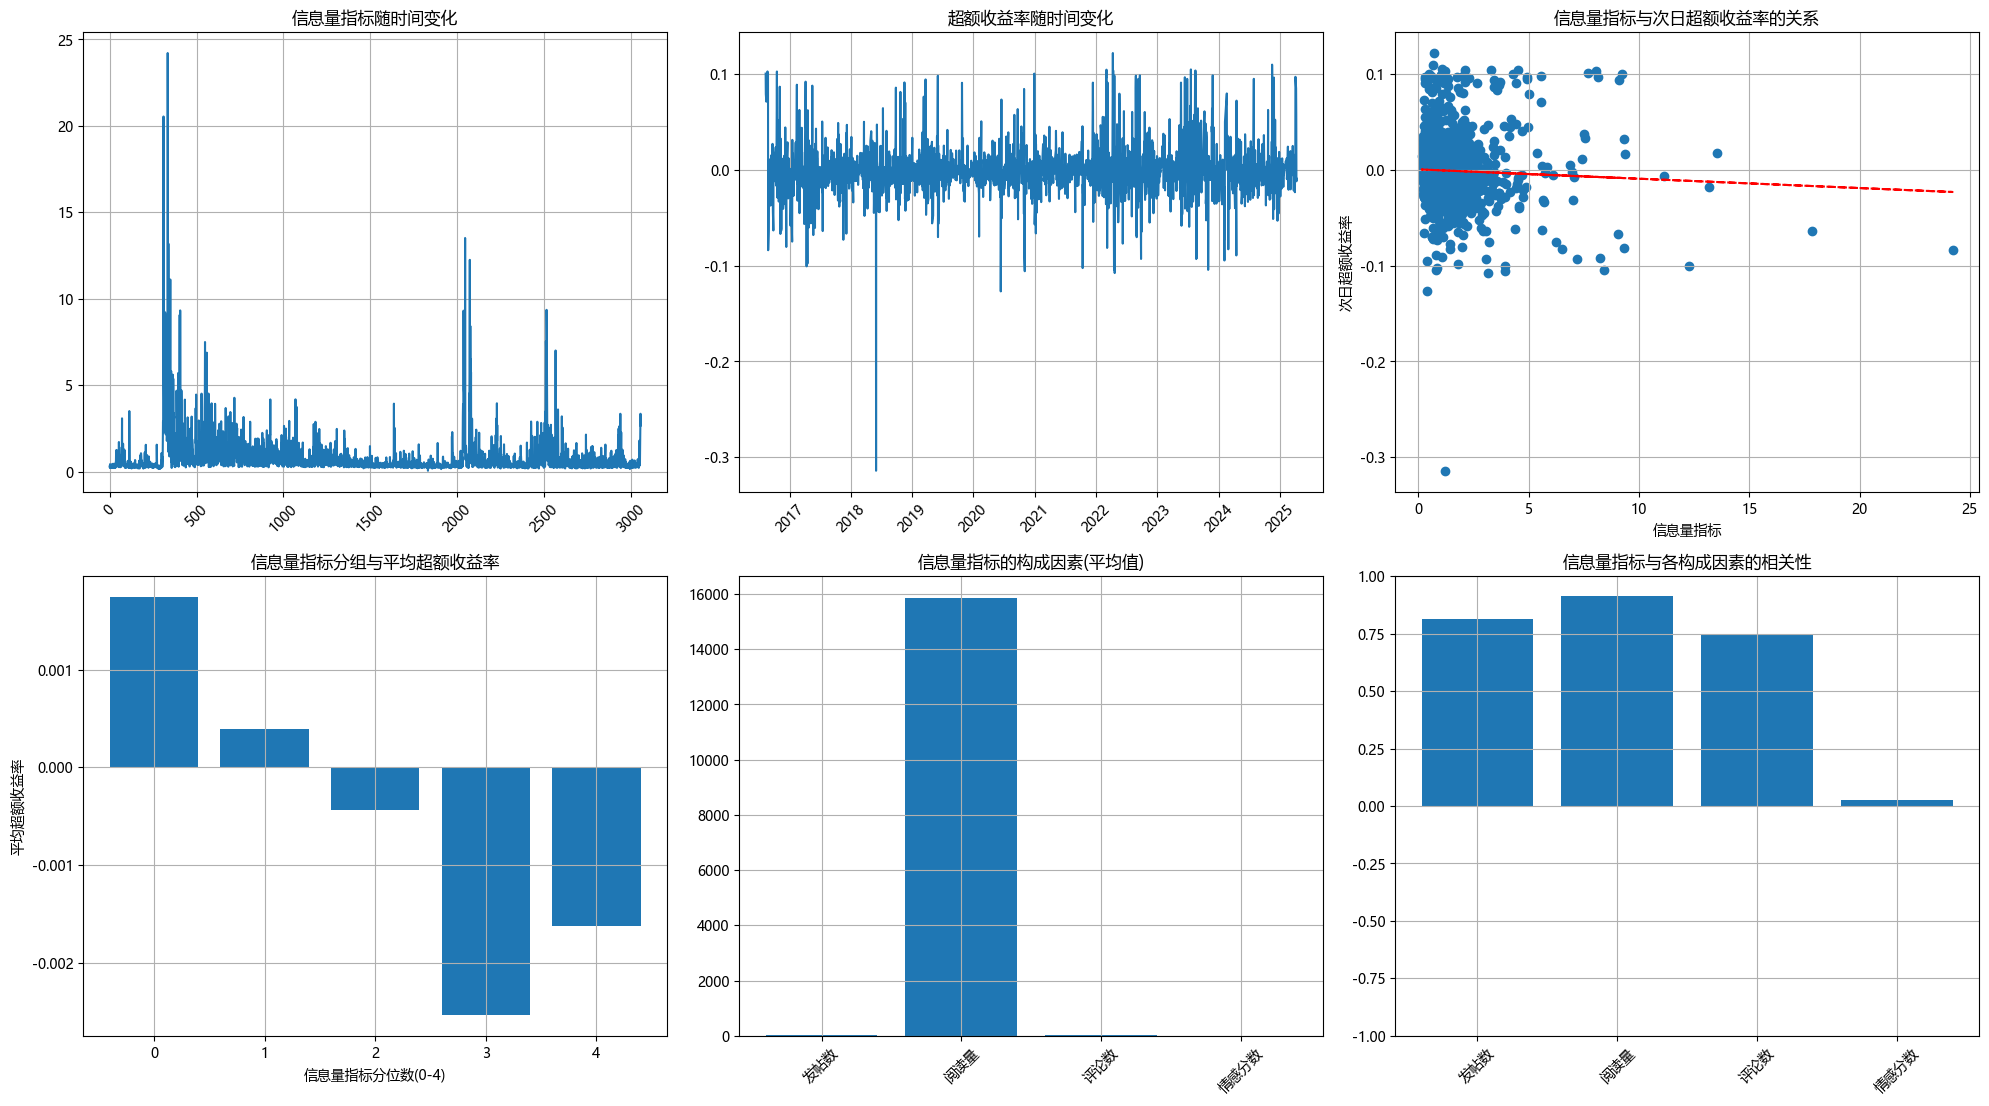

In [49]:
with open('./assets/data/data_guba_cjwl.csv', 'r', encoding='utf-8') as f:
    bbs_data_str = f.read()
with open('./assets/data/data_sina_cjwl.json', 'r', encoding='utf-8') as f:
    stock_data_json = f.read()

tushare_token = '2207b01a244311f7742512463d9e1588954d174b86d695f8a9f1cc4b'

start_date = '2016-08-10'  
end_date = '2025-04-10'
index_data_json = get_index_data_json_tushare(start_date, end_date, token=tushare_token)

results = motion_pipeline(bbs_data_str, stock_data_json, index_data_json)